# Training on GPU

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)

cuda:0


# Load data

In [40]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [41]:
trainset=torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

Files already downloaded and verified


In [42]:
trainloader=torch.utils.data.DataLoader(trainset,batch_size=4,
                                              shuffle =True, num_workers=2)
testset=torchvision.datasets.CIFAR10(root='./data', 
                                     train=False,download=True, 
                                     transform=transform)
testloader=torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)
classes=('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


# Test Graph

In [6]:
import matplotlib.pyplot as plt
import numpy as np

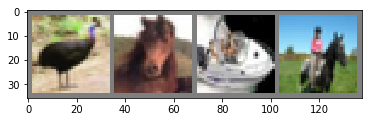

 bird horse  ship horse


In [43]:
def imshow(img):
    img=img/2+0.5 #normalize
    nping=img.numpy()
    plt.imshow(np.transpose(nping,(1,2,0)))
    plt.show()

dataiter=iter(trainloader)
images, labels=dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


# Network definition

In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [47]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1=nn.Conv2d(3,1600,5)
        self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(1600,16,5)
        #y=Wx+b
        self.fc1=nn.Linear(16*5*5,120) #6x6 img size
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
    
    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=x.view(-1, 16*5*5)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x
    
net=Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 1600, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(1600, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

# Loss definition & optimizer

In [45]:
import torch.optim as optim

In [48]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
print (optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


# Training

In [49]:
for epoch in range(2):
    
    running_loss=0.0
    for i, data in enumerate(trainloader,0):
        #get input
        inputs, labels = data[0].to(device), data[1].to(device)
        
        #zero the param gradients
        optimizer.zero_grad()
        
        #forward+backward+opti
        net.to(device)
        outputs=net(inputs)
        loss=criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #print stats
        running_loss +=loss.item()
        if i % 2000==1999: #print every 2000 mini batches
            print('[%d, %5d] loss: %.3f'
                 % (epoch+1,i+1,running_loss/2000))
            running_loss=0.0
            
print('Finished Training')
        

[1,  2000] loss: 1.907
[1,  4000] loss: 1.623
[1,  6000] loss: 1.558
[1,  8000] loss: 1.456
[1, 10000] loss: 1.403
[1, 12000] loss: 1.378
[2,  2000] loss: 1.289
[2,  4000] loss: 1.248
[2,  6000] loss: 1.258
[2,  8000] loss: 1.242
[2, 10000] loss: 1.216
[2, 12000] loss: 1.158
Finished Training


# Test the trained network


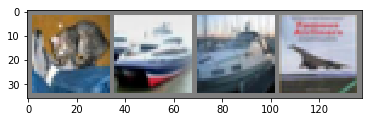

GroundTruth:    cat  ship  ship plane


In [50]:
dataiter=iter(testloader)
images, labels=dataiter.next()
#print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ',' '.join('%5s'%classes[labels[j]] for j in range(4)))

In [53]:

outputs=net(images.to(device))

In [54]:
_, predicted=torch.max(outputs,1)
print ('predicted: ', ' '.join('%5s' % classes[predicted[j]] 
                               for j in range(4)))

predicted:    cat  ship  ship  ship


In [65]:
correct=0
total=0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs=net(images.to(device))
        _, predicted=torch.max(outputs.data, 1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()

print ('acccuracy log the network on the 10000 test images: %d %%' % (
    100*correct/total))

acccuracy log the network on the 10000 test images: 9 %


In [64]:
class_correct=list(0. for i in range(10))
class_total=list(0. for i in range(10))
with torch.no_grad():
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs=net(images.to(device))
        _, predicted=torch.max(outputs,1)
        c=(predicted==labels).squeeze()
        for i in range(4):
            label=labels[i]
            class_correct[label]+=c[i].item()
            class_total[label]+=1
            
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100*class_correct[i]/class_total[i]))
    

Accuracy of plane :  0 %
Accuracy of   car :  0 %
Accuracy of  bird :  0 %
Accuracy of   cat : 25 %
Accuracy of  deer :  0 %
Accuracy of   dog :  0 %
Accuracy of  frog :  0 %
Accuracy of horse :  0 %
Accuracy of  ship : 74 %
Accuracy of truck :  0 %
